<a href="https://colab.research.google.com/github/Akshatpattiwar512/Principal-Component-Analysis/blob/main/Credit_Card_Dataset_for_Clustering_using_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download arjunbhasin2013/ccdata

  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 49.2MB/s]


In [6]:
! unzip ccdata.zip

Archive:  ccdata.zip
  inflating: CC GENERAL.csv          


## Installing libraries / dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")

import os
print(os.listdir("/content"))

['.config', 'ccdata.zip', '.ipynb_checkpoints', 'CC GENERAL.csv', 'kaggle.json', 'sample_data']


In [11]:
data= pd.read_csv("../content/CC GENERAL.csv")
print(data.shape)
data.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Preprocessing

In [12]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Dealing with Missing Values

In [13]:
data.isnull().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS       313
CREDIT_LIMIT             1
TENURE                   0
PURCHASES_FREQUENCY      0
BALANCE                  0
dtype: int64

Replacing missing values with mean

In [14]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean()
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=data['CREDIT_LIMIT'].mean()

In [15]:
data.isnull().sum().sort_values(ascending=False).head()

TENURE               0
PRC_FULL_PAYMENT     0
BALANCE              0
BALANCE_FREQUENCY    0
PURCHASES            0
dtype: int64

In [16]:
columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0        
    data.loc[((data[c]>0)&(data[c]<=500)),Range]=1
    data.loc[((data[c]>500)&(data[c]<=1000)),Range]=2
    data.loc[((data[c]>1000)&(data[c]<=3000)),Range]=3
    data.loc[((data[c]>3000)&(data[c]<=5000)),Range]=4
    data.loc[((data[c]>5000)&(data[c]<=10000)),Range]=5
    data.loc[((data[c]>10000)),Range]=6

In [17]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=0.1)),Range]=1
    data.loc[((data[c]>0.1)&(data[c]<=0.2)),Range]=2
    data.loc[((data[c]>0.2)&(data[c]<=0.3)),Range]=3
    data.loc[((data[c]>0.3)&(data[c]<=0.4)),Range]=4
    data.loc[((data[c]>0.4)&(data[c]<=0.5)),Range]=5
    data.loc[((data[c]>0.5)&(data[c]<=0.6)),Range]=6
    data.loc[((data[c]>0.6)&(data[c]<=0.7)),Range]=7
    data.loc[((data[c]>0.7)&(data[c]<=0.8)),Range]=8
    data.loc[((data[c]>0.8)&(data[c]<=0.9)),Range]=9
    data.loc[((data[c]>0.9)&(data[c]<=1.0)),Range]=10

In [18]:
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']  

for c in columns:
    
    Range=c+'_RANGE'
    data[Range]=0
    data.loc[((data[c]>0)&(data[c]<=5)),Range]=1
    data.loc[((data[c]>5)&(data[c]<=10)),Range]=2
    data.loc[((data[c]>10)&(data[c]<=15)),Range]=3
    data.loc[((data[c]>15)&(data[c]<=20)),Range]=4
    data.loc[((data[c]>20)&(data[c]<=30)),Range]=5
    data.loc[((data[c]>30)&(data[c]<=50)),Range]=6
    data.loc[((data[c]>50)&(data[c]<=100)),Range]=7
    data.loc[((data[c]>100)),Range]=8

In [19]:
data.drop(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY',  'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT' ], axis=1, inplace=True)

X= np.asarray(data)

Normalizing input values.

In [20]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

## MODELING

Clustering using Kmeans

In [21]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)

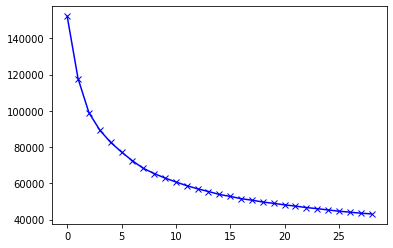

In [22]:
plt.plot(cost, 'bx-')

Choosing 6 no of clusters

In [23]:
kmean= KMeans(6)
kmean.fit(X)
labels=kmean.labels_

In [24]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,0
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,2
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,1
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,0
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,0


## Interpretation of Clusters

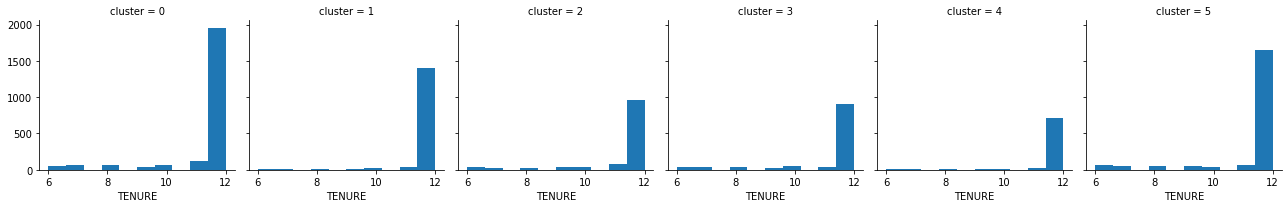

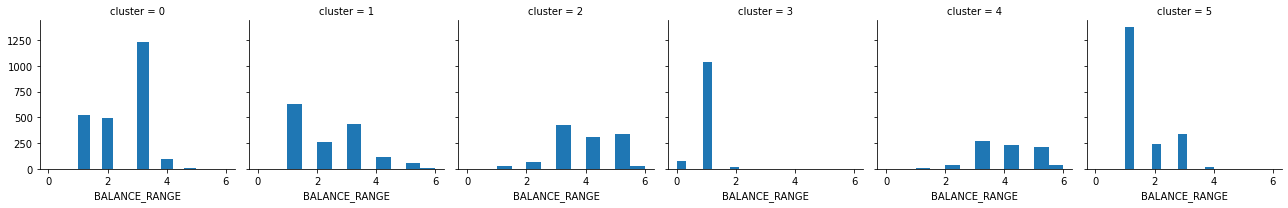

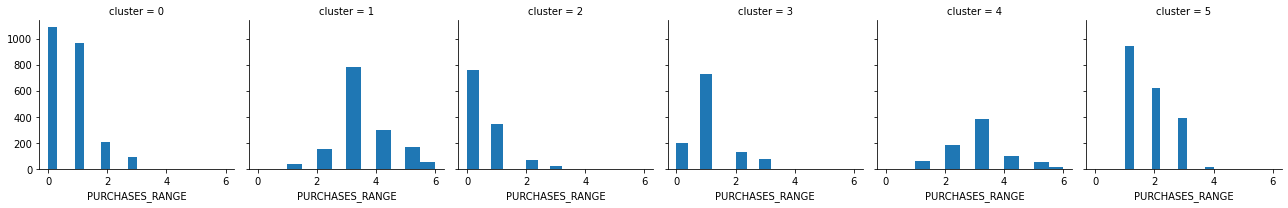

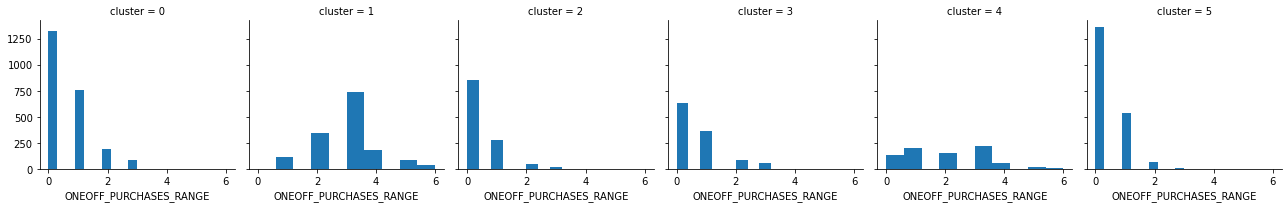

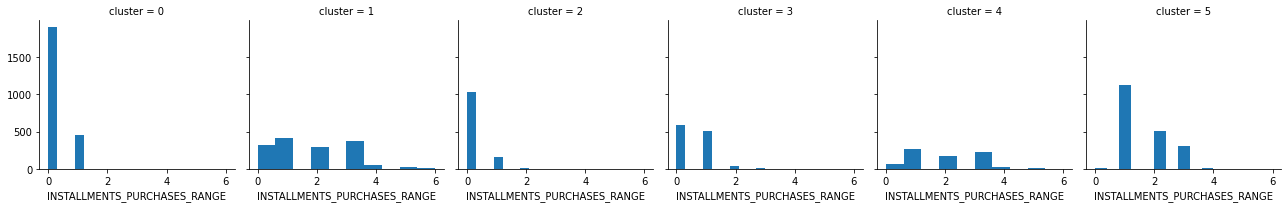

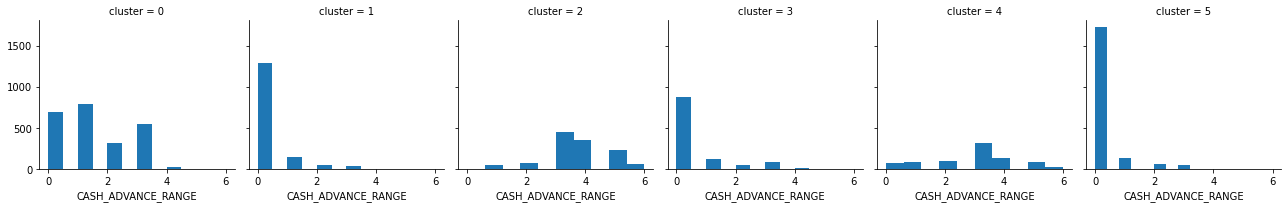

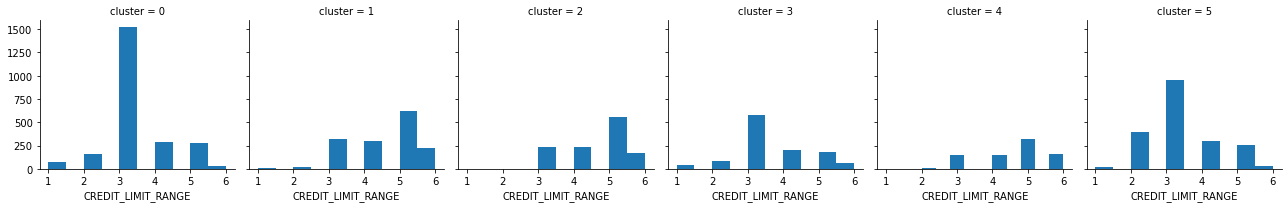

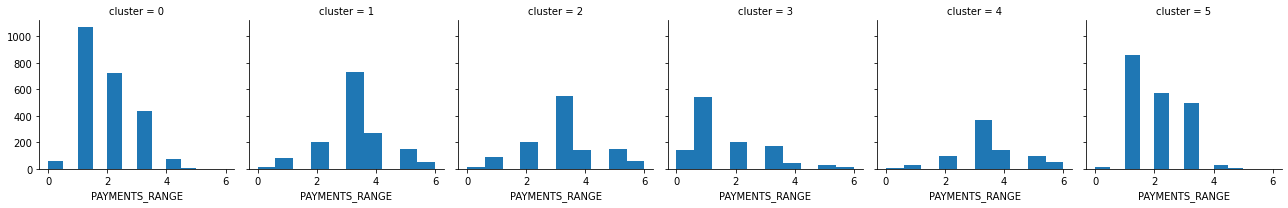

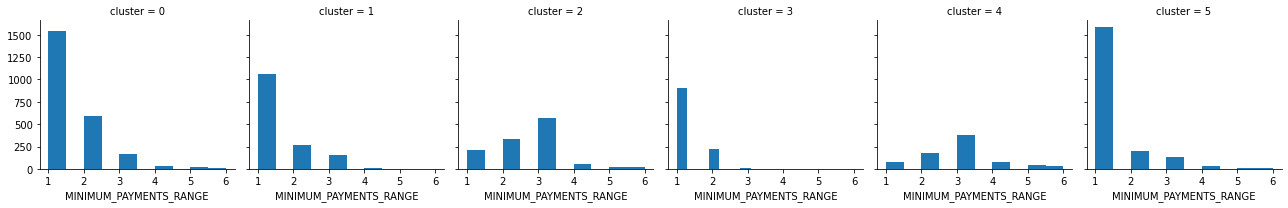

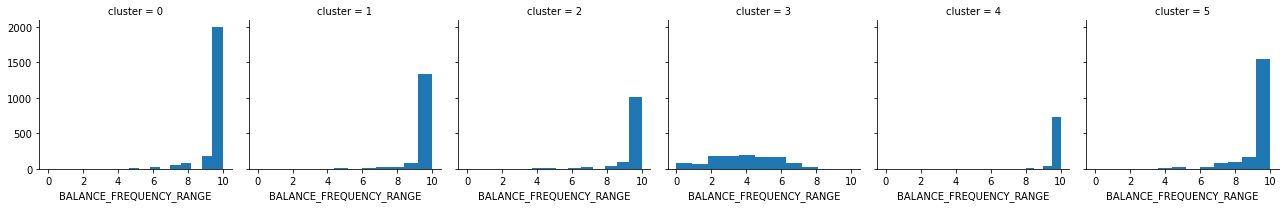

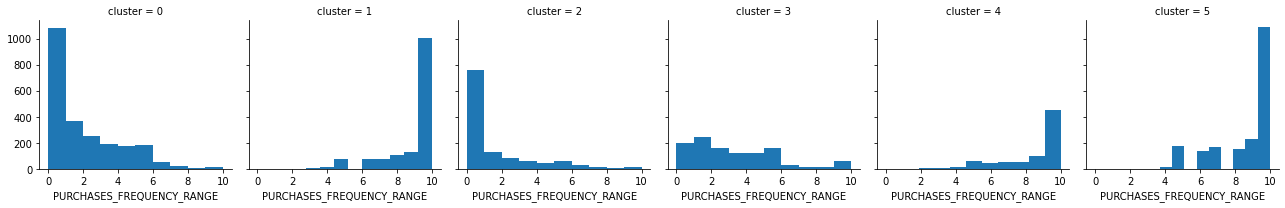

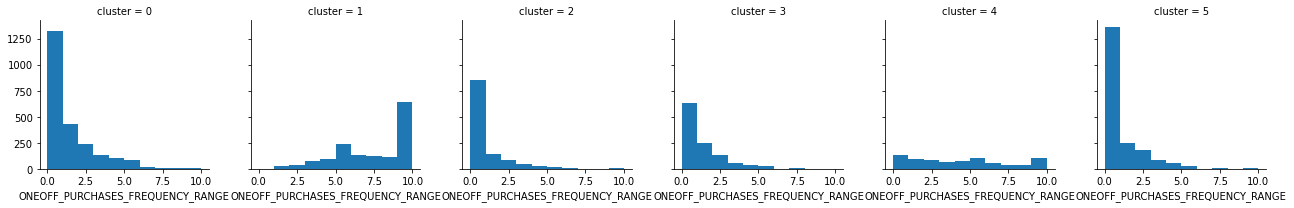

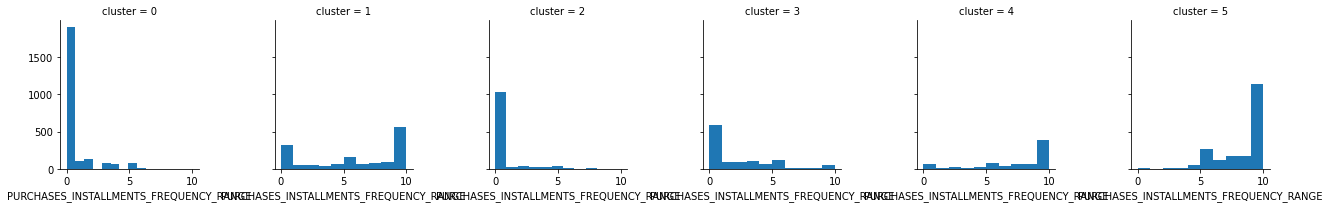

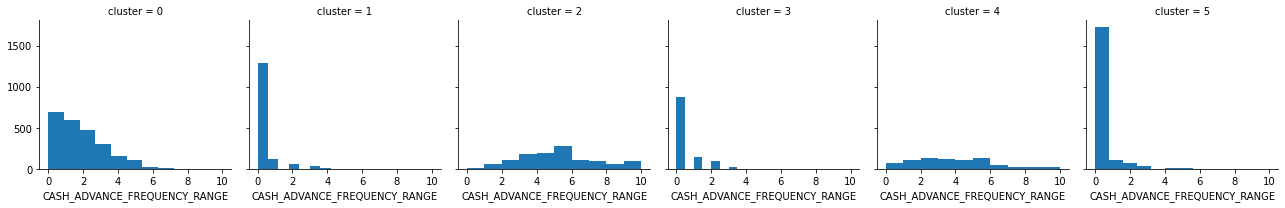

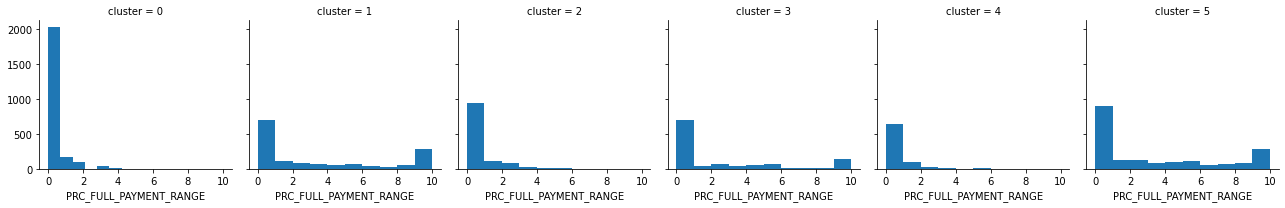

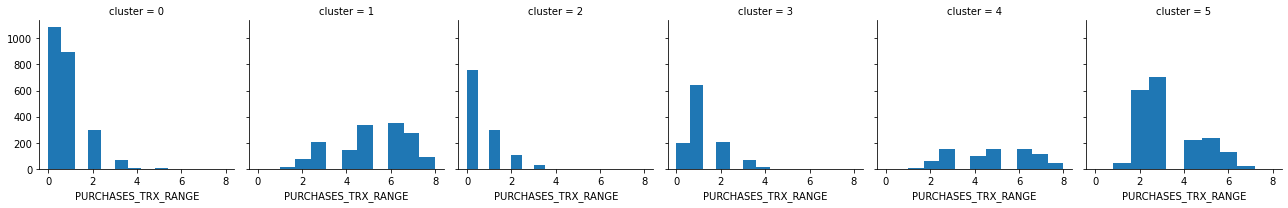

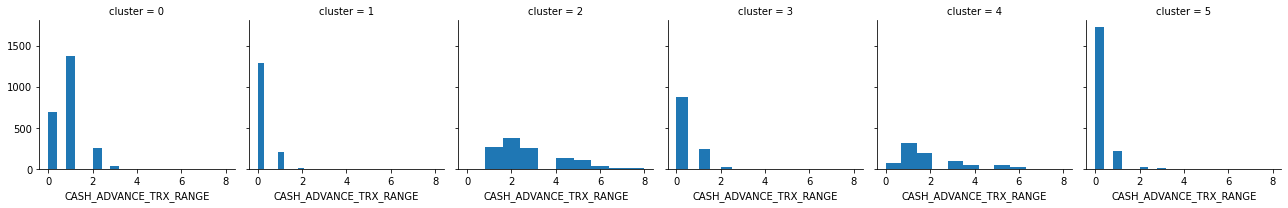

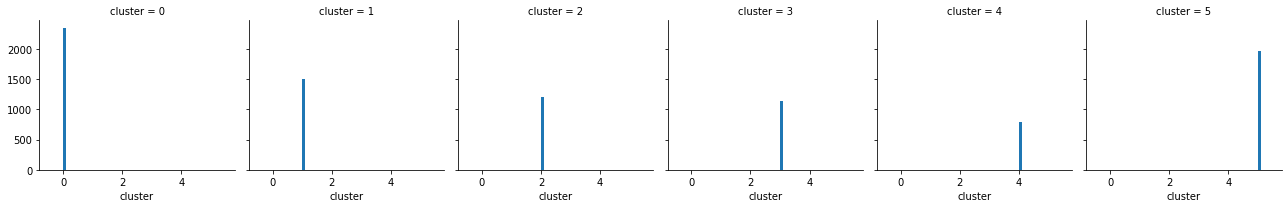

In [25]:
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

## Visualization of Clusters

Using PCA to transform data to 2 dimensions for visualization


In [26]:
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

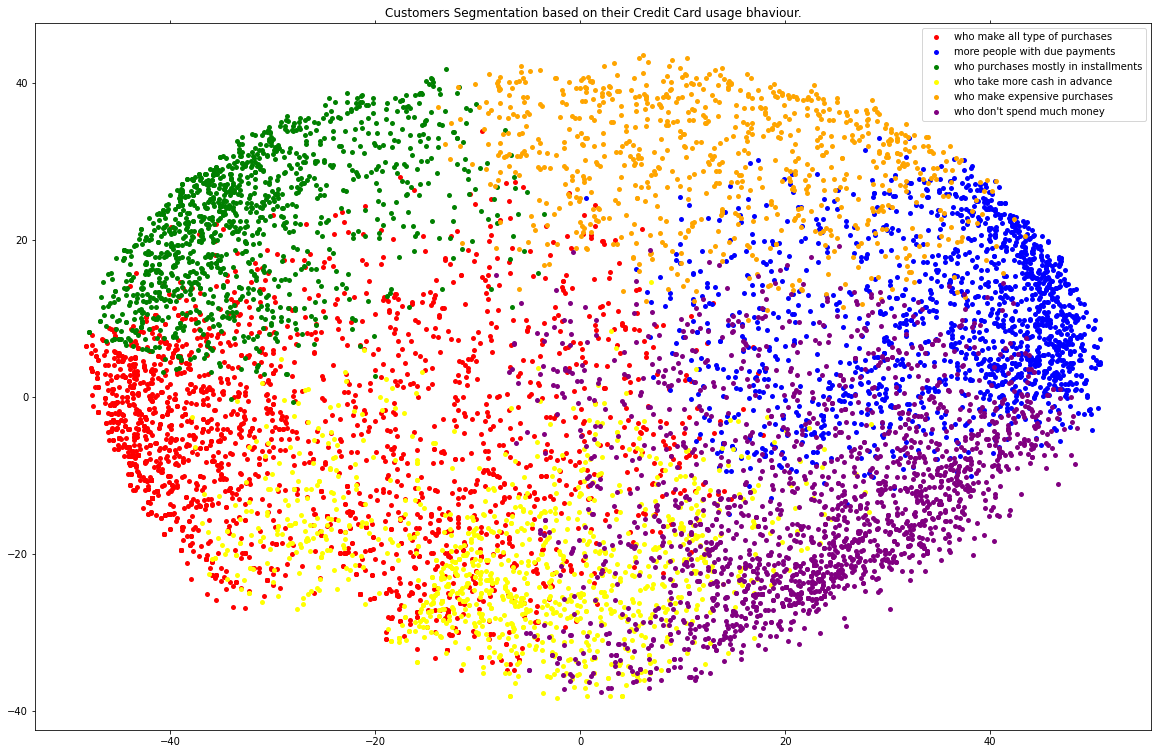

In [27]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple'}

names = {0: 'who make all type of purchases', 
         1: 'more people with due payments', 
         2: 'who purchases mostly in installments', 
         3: 'who take more cash in advance', 
         4: 'who make expensive purchases',
         5:'who don\'t spend much money'}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()